# Particles

In [2]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [3]:
# ---------------------------- SIMULATION CHECKING FUNCTIONS ----------------------------


def ls(path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix='' , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0, only_sim_obj = True):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    if only_sim_obj:
        file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
        matching_files = glob.glob(file_pattern)
        if matching_files:
            with open(matching_files[0], 'r') as file:
                config = yaml.load(file, Loader=yaml.FullLoader)
                obj_list = config['run']['save_list']

    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP', 'BLM', 'TCLA', 'TFT']:
                if only_sim_obj:
                    if any([file_lines[i-1] in obj for obj in obj_list]):
                        print(file_lines[i-1]+suffix+' = '+file_lines[i])
                else:    
                    print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])



def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
    matching_files = glob.glob(file_pattern)
    if matching_files:
        with open(matching_files[0], 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])


def check_hdf_keys(input_path):
    with pd.HDFStore(input_path, 'r') as store:
         keys = store.keys()
    for key in keys:
        print(key)


def display_rows(rows = None, cols = None):
    pd.set_option('display.max_rows', rows)
    pd.set_option('display.max_columns', cols)



In [4]:
# ----------------------------- TURN AND COMPARISON FUNCTIONS ----------------------------


def plot_at_turn(TCCS, TARGET, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part()
    df_TARGET_all = TARGET.data

    df_TCCS = df_TCCS[df_TCCS['this_turn']==n_turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==n_turn]
    df_TARGET_all = df_TARGET_all[df_TARGET_all['this_turn']==n_turn]

    print("IMPACT ON TCCS AT TURN ", n_turn)    
    fig_TCCS, ax_TCCS_list = TCCS.plot_distributions(df_TCCS['x'], df_TCCS['y'], df_TCCS['px'], df_TCCS['py'], xpcrit=True, return_fig=True, percentile = percentile)
    if plot_whole:
        ax_TCCS_list[1].hist(TCCS.data['y'], bins=100, alpha = 0.3) 
        ax_TCCS_list[2].scatter(TCCS.data['x'], TCCS.data['y'], alpha = 0.03, zorder=1) 
        ax_TCCS_list[4].hist(TCCS.data['py'], bins=100, alpha = 0.3) 

    print("IMPACT ON TARGET AT TURN ", n_turn)    
    fig_TARGET, ax_TARGET_list = TARGET.plot_distributions(df_TARGET['x'], df_TARGET['y'], df_TARGET['px'], df_TARGET['py'],  return_fig=True, percentile = percentile)
    if plot_whole:
        ax_TARGET_list[2].scatter(TARGET.data['x'], TARGET.data['y'], alpha = 0.03, zorder=1) 

    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]

    print('TCCS impacts: ', len(df_TCCS), '\ninside critical angle:', len(channable)  ,'\nTARGET impacts' ,len(df_TARGET), '\nCommon impacts: ', len(common_ids))

    df_common = df_TCCS[df_TCCS['particle_id'].isin(common_ids)]
    print("\nIMPACTS ON TARGET FROM TCCS AT TURN ", n_turn)    
    fig_common, ax_common_list = TCCS.plot_distributions(df_common['x'], df_common['y'], df_common['px'], df_common['py'], xpcrit=True, return_fig=True)

    if plot_chann:
        ax_TCCS_list[2].scatter(df_common['x'], df_common['y'], color='pink',zorder=10, alpha =0.01) 
        ax_TCCS_list[4].hist(df_common['py'], bins=90, alpha = 0.3, color='pink')


def check_plot_turns(TCCS, TARGET, turns=200):
    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part()
    tccs, target, channable, common = [], [], [], []
    x = np.arange(turns)
    for t in range(turns):
        tccs.append(len(df_TCCS[df_TCCS['this_turn']==t]))
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))
        tmp_TCCS = df_TCCS[df_TCCS['this_turn']==t]
        tmp_target = df_TARGET[df_TARGET['this_turn']==t]
        common_ids = np.intersect1d(tmp_TCCS['particle_id'], tmp_target['particle_id'])
        channable.append(len(tmp_TCCS[(tmp_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (tmp_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]))
        common.append(len(tmp_TCCS[tmp_TCCS['particle_id'].isin(common_ids)]))

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(x, tccs, label='TCCS impacts')
    ax.plot(x, target, label='TARGET impacts')
    ax.plot(x, channable, label='TCCS impacts inside critical angle')
    ax.plot(x, common, label='Common impacts')
    #ax.set_yscale('log')
    ax.legend()
    print(np.argmax(target))



def plot_turn_impacts(impact_list, turns=200, threshold=10000, labels = None, linestyles = None, return_fig = False):
    if not hasattr(impact_list, '__iter__'):
            impact_list = [impact_list]
    dfs = [i.impact_part() for i in impact_list]

    x = np.arange(turns)
    fig, ax = plt.subplots(figsize=(10, 7))

    for i, df in enumerate(dfs):
        imp = []
        for t in range(turns):
            imp.append(len(df[df['this_turn']==t]))

        if labels is not None:
            label=labels[i]
        else:
             label = f'impacts {i}'
        if linestyles is not None:
            linestyle=linestyles[i]
        else:
            linestyle = '-'
        ax.plot(x, imp, label=label, linewidth=2, linestyle=linestyle, marker='o')
        peaks = []
        for i in range(1, len(imp)):
            if imp[i] - imp[i-1] > threshold:
                peaks.append(i)
        print('\nPeaks at turns: ', peaks)       
        print('Absolute max: ', np.argmax(imp))

    ax.legend()
    ax.set_xlabel('Turn number')
    ax.set_ylabel('N impacts')

    if return_fig:
        return fig, ax  

def calculate_target_impacts_threshold(TARGET, threshold , turns=200):
    df_TARGET = TARGET.impact_part()
    target = []
    x = np.arange(turns)
    for t in range(turns):
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))

    print('thershold: ', threshold, 'before thershold: ', np.sum(target[:threshold]), f"{  (np.sum(target[:threshold])/np.sum(target)*100):.{1}f}% \t after thershold: ", np.sum(target[threshold:]), f"   {(np.sum(target[threshold:])/np.sum(target)*100):.{1}f}%")

##### class

In [5]:
class ParticleAnalysis():

    def __init__(self, n_sigma, length, sigma, xdim = None, ydim = None, beam = 2, plane = 'V', jaw_L = None, emittance_n = 3.5e-6):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        if jaw_L is not None:
            self.jaw_L = jaw_L
        else:
            self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.gamma0 = None
        self.beta0 = None
        self.charge = None
        self.mass = None
        self.emittance_n = emittance_n
        self.emittance = None

        if xdim is not None and ydim is not None:
            if self.plane == 'H':
                self.abs_y_low = -self.ydim/2
                self.abs_y_up = self.ydim/2
                self.abs_x_low = self.jaw_L
                self.abs_x_up = self.jaw_L + self.xdim
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = self.jaw_L + self.ydim
                self.abs_x_low = -self.xdim/2
                self.abs_x_up = self.xdim/2
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
        else:
            if self.plane == 'H':
                self.abs_y_low = None
                self.abs_y_up = None
                self.abs_x_low = self.jaw_L
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = None
                self.abs_x_low = None
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.coll_names = {'TCCS': 'tccs.5r3.b2', 'TCCP': 'tccp.4l3.b2', 'TARGET': 'target.4l3.b2', 'TCLA': 'tcla.a5l3.b2'}
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/", Condor = True, n_return = None):
        
        if Condor:
            test_list = [path + i for i in os.listdir(path) if prefix_name in i]
            for test_name in test_list:

                n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

                path_list =[]

                for i in range(n_jobs):
                    file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                    if os.path.exists(file_path_part):
                        path_list.append(file_path_part)

                n_jobs_verify  = len(path_list)
                if n_jobs != n_jobs_verify:
                    print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        else:
            path_list = (subprocess.check_output("echo " + path + prefix_name +file_name, shell=True)).decode('ascii').strip()
        
        if not hasattr(path_list, '__iter__') or isinstance(path_list, str):
            path_list = [path_list]

        if n_return is not None:
            return path_list[:n_return]
        else:
            return path_list   
    


    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       n_return = None,
                       part_per_job = 100000,
                       **kwargs):

        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return)       
        if Condor == True:
            self.part_per_job = part_per_job
            self.n_jobs = len(h5_file_path)

        df_particles = pd.DataFrame()
        npart = 0
        for file in h5_file_path:

            job_id = int(file.split('Job.')[1].split('/')[0]) if Condor else 0
            
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                                               
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*job_id    
                if 'at_element' in df_tmp.columns and df_tmp['at_element'].dtype == 'int32':
                    try:
                        idx_table = pd.read_hdf(file, key='idx').to_dict()[0]
                        df_tmp['at_element'] = df_tmp['at_element'].map(idx_table)
                    except:
                        pass
            
                for col in ['interactions']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)
                
                for col in ['TCCP_turn', 'TCCS_turn', 'CRY_turn']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)           
                        df_tmp[col] = df_tmp[col].apply(lambda x: [int(i) if i != 'None' else i for i in x] )
                        df_tmp[col] = df_tmp[col].apply(lambda x: [] if 'None' in x else x)                
                
                TCP_turns = []

                if 'TCP_turn' in df_tmp.columns:
                    for s in df_tmp['TCP_turn']:
                        TCP_turns.append(ast.literal_eval(f'[{s}]') if s != "None" else [[],[],[]]) 
                    df_tmp['TCP_turn'] = TCP_turns
                
                df_particles = pd.concat([df_particles, df_tmp])

            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)

                  
        self.npart = npart

        if 'p0c' in df_particles.columns:     
            if len(df_particles['p0c'].unique()) == 1:
                p0c = df_particles['p0c'].unique()[0]
            else:
                print('There are particles at different energies')            
            self.p0c = p0c
        else:
            metadata = pd.read_hdf(h5_file_path[0], key='metadata').to_dict()[0]

            self.p0c = metadata['p0c']
            self.gamma0 = metadata['gamma0']
            self.beta0 = metadata['beta0']
            self.charge = metadata['q0']
            self.mass = metadata['mass0']
            self.emittance = self.emittance_n / (self.gamma0 * self.beta0)


        return df_particles
    
    def impact_part(self):
        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = self.data['x'] >= self.abs_x_low
            elif self.plane == 'V':
                hit_mask = self.data['y'] >= self.abs_y_low
        else:
            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        return self.data[hit_mask]   
    
    def get_job_id(self, abs_id, TCCS = None):
        
        if not hasattr(abs_id, '__iter__') or isinstance(abs_id, str):
            abs_id = [abs_id]
        elif isinstance(abs_id, pd.Series):
            abs_id = abs_id.to_list()

        for id in abs_id:
            print(f'\nabs_id: {id}')
            if TCCS is not None:
                df_tccs = TCCS.data
                df_tccs = df_tccs[df_tccs['particle_id'] == id]
                if len(df_tccs==1):
                    print('Part is in TCCS')
                    if df_tccs.py.iloc[0] > TCCS.align_angle - np.abs(TCCS.xp_crit) and df_tccs.py.iloc[0] < TCCS.align_angle + np.abs(TCCS.xp_crit):
                        print('Part in critical angle')
                    else:   
                        print('Part is NOT in critical angle')
                else:
                    print('Particle is NOT in TCCS')
               
                
            number = id/self.part_per_job
            integer_part = int(divmod(number, 1)[0])

            fractional_part = int(np.round((number % 1) * self.part_per_job))

            print('Turn of channeling: ', self.data[self.data['particle_id'] == id].this_turn.iloc[0])
            print(f"Job Number: {integer_part}, ID: {fractional_part} ")

    def hist_jobs(self):   
        jobs = divmod(self.data['particle_id']/self.part_per_job, 1)[0]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(jobs, bins=self.n_jobs)
        ax.set_xlabel('job_id')
        ax.set_ylabel('n_part')    

    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r'):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor='none', zorder=zorder, linewidth=linewidth)
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y, bins = 100, axins_params = ["100%", "5%", "right", -6], sigma_line = True,**kwargs):
       

        h = ax.hist2d(x, y, bins=bins, norm=matplotlib.colors.LogNorm(), zorder=2)
    
        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])
        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_xticks()])
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_yticks()])
        

        if self.plane == 'V':

            ax_tw = ax.twinx()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_ylim((ax.get_ylim()[0]-self.ref)/sigma_abs, (ax.get_ylim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
            ax_tw.set_yticks(yticks)
            ax_tw.set_ylabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')


        elif self.plane == 'H':

            ax_tw = ax.twiny()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_xlim((ax.get_xlim()[0]-self.ref)/sigma_abs, (ax.get_xlim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 20 and ax_tw.get_xlim()[0] - ax_tw.get_xlim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 60 and ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_xlim()[0]), np.floor(ax_tw.get_xlim()[1]) + 1, n_ticks)
            ax_tw.set_xticks(yticks)
            ax_tw.set_xlabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axvline(self.n_sigma, color = 'r', linestyle = '--')

        axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')

        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
            ax_tw.set_ylim((kwargs['ylim'][0]-self.ref)/sigma_abs, (kwargs['ylim'][1]-self.ref)/sigma_abs)
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])

            


    def plot_ang_distribution(self, fig, ax, py, bins = 100, fit = None, **kwargs):
        ax.hist(py, bins=bins) 
        if self.plane == 'V':
            ax.set_xlabel(r'py [$\mu$rad]')
        elif self.plane == 'H':
            ax.set_xlabel(r'px [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax.get_xticks()])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions_base(self, x, y, px, py, 
                                bins_x = 100, bins_y = 100, bins_px= 100, bins_py = 100,
                                fit = None, return_fig = False, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']

        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = x >= self.abs_x_low
            elif self.plane == 'V':
                hit_mask = y >= self.abs_y_low
        else:
            hit_mask = ((x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y<= self.abs_y_up))
        
        hitting_particles = sum(hit_mask)

        if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            pym = (py >= py_min) & (py <= py_max)
        
            px_min = np.percentile(px,kwargs['percentile'])
            px_max = np.percentile(px,100-kwargs['percentile'])
            pxm = (px >= px_min) & (px <= px_max)

            y_min = np.percentile(y,kwargs['percentile'])
            y_max = np.percentile(y,100-kwargs['percentile'])
            ym = (y >= y_min) & (y <= y_max)
         
            x_min = np.percentile(x,kwargs['percentile'])
            x_max = np.percentile(x,100-kwargs['percentile'])
            xm = (x >= x_min) & (x <= x_max)

        else:
            pym = np.ones(len(py), dtype=bool)
            pxm = np.ones(len(px), dtype=bool)
            ym = np.ones(len(y), dtype=bool)
            xm = np.ones(len(x), dtype=bool)
            
        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x[xm & ym], bins=bins_x)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        if lines:
            ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
            ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=ax1.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax1.get_xticks()])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y[xm & ym], bins=bins_y) 
        ax2.set_xlabel('y [mm]')
        if lines:
            ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
            ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=ax2.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax2.get_xticks()])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)

        ax12 = fig1.add_subplot(2,3,4)
        ax22 = fig1.add_subplot(2,3,5)

        if self.plane == 'V':
        
            ax12.hist(px[pxm & pym & hit_mask], bins=bins_px)
            ax12.set_xlabel(r'px [$\mu$rad]')
            ax12.set_ylabel("")        
            ax12.set_xticks(ticks=ax12.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax12.get_xticks()])
      
            self.plot_ang_distribution(fig1, ax22, py[pym & pxm & hit_mask], bins = bins_py, **kwargs)

        elif self.plane == 'H':

            self.plot_ang_distribution(fig1, ax12, px[pym & pxm & hit_mask], bins = bins_px, **kwargs)
            
            ax22.hist(py[pxm & pym & hit_mask], bins=bins_py)
            ax22.set_xlabel(r'py [$\mu$rad]')
            ax22.set_ylabel("")        
            ax22.set_xticks(ticks=ax22.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax22.get_xticks()])
      
   


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px[hit_mask], py[hit_mask], bins=(bins_px, bins_py), norm=matplotlib.colors.LogNorm(), zorder=2)  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=ax32.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_xticks()])
        ax32.set_yticks(ticks=ax32.get_yticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_yticks()])
        if len(px[hit_mask]) > 0:
            axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
            fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        if return_fig:
            return fig1, [ax1, ax2, ax3, ax12, ax22, ax32]  
        else:
            plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss


    # BBBBBB
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, return_fig = False, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit
        if return_fig:
            return self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], return_fig = return_fig ,  sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, **kwargs)
        else:
            self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, **kwargs)

    def plot_phasespace(self, impacts = False, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        if impacts:
            px, py, x, y = self.impact_part()['px'], self.impact_part()['py'], self.impact_part()['x'], self.impact_part()['y']
        else:
            px, py, x, y  = self.data['px'], self.data['py'], self.data['x'], self.data['y']
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(x, px, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(y,py, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')

        if self.plane == 'V':
            ax2.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax2.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax2.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax2.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')
        elif self.plane == 'H':
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax1.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax1.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax1.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')

        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, show_zoom = zoom,  outfile = outfile)

    def plot_lossmap(self, zoom = None, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", outfile = None):

        if zoom == 'IR7':
            lm.plot_lossmap(self.lossmap, show_zoom = True,   outfile = outfile)
        elif zoom == 'IR3':
            lm.plot_lossmap(self.lossmap, zoom_range = [6000,7200],  outfile = outfile)
        else:
            lm.plot_lossmap(self.lossmap, show_zoom = False,   outfile = outfile)
            
    def compute_losses(self, path=None, ):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        names = ['tcp.d6r7.b2', 'tcp.c6r7.b2', 'tcp.b6r7.b2', 'tcla.a5l3.b2',  'tccp.4l3.b2', 'tccs.5r3.b2']
        df_losses = pd.concat([df.query('name in @names'),df[df.losses_N > np.mean(df.losses_N)]]).drop_duplicates(keep='first', subset=df.columns)
        self.losses = pd.merge(df_losses, self.lossmap.inefficiency()[['losses', 's']], on = 's').drop('losses_dE', axis = 1).sort_values(by='s', ascending=True)
        return self.losses

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')

    def count_interactions(self):
        if 'interactions' in self.data.columns:
            data = self.data['interactions'].apply(lambda x: str(x))
            data = data.groupby(data).count()
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            print(data)
            if 'nan' in data.index:
                data = data.drop('nan')
            pd.set_option('display.max_rows', 30)
            pd.set_option('display.max_columns', 30)
            print(f"\n ---- Total interacting particles: {data.sum()} ---- \n")
        else:
            print('No interaction data available')





# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, jaw_L = None,  bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2, #eV/m Silicon    #dp_Si = 1.92e-10 #m
                eta = 0.9,
                xp_version = 'code',
                miscut = 0.0, **kwargs
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma, jaw_L = jaw_L)

    self.miscut = miscut
    self.align_angle = align_angle + self.miscut
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 
    self.eta = eta
    self.xp_version = xp_version
    self.n_CRY_absorbed = None
    self.n_TCCS_absorbed = None
    self.n_TCCP_absorbed = None


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 100000,
                      get_absorbed = 'all'): #all, only, not

    if get_absorbed in ['all', 'not']:
        self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)
        if 'TCP_turn' in self.data.columns:   
            self.data = self.data[ ['particle_id', 'x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'interactions', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
        
    if get_absorbed in ['all', 'only']:
        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return) 
        n_absorbed_CRY  = 0
        n_absorbed_TCCS = 0
        n_absorbed_TCCP = 0
        for file in h5_file_path:
            metadata = pd.read_hdf(file, key='metadata').to_dict()[0]
            if 'CRY_absorbed' in metadata.keys():
                n_absorbed_CRY = n_absorbed_CRY + metadata['CRY_absorbed']
            if 'TCCS_absorbed' in metadata.keys():
                n_absorbed_TCCS = metadata['TCCS_absorbed']
            if 'TCCP_absorbed' in metadata.keys():
                n_absorbed_TCCP = metadata['TCCP_absorbed']
        
        self.n_CRY_absorbed = int(n_absorbed_CRY) if 'CRY_absorbed' in metadata.keys() else None 
        self.n_TCCS_absorbed = int(n_absorbed_TCCS) if 'TCCS_absorbed' in metadata.keys() else None
        self.n_TCCP_absorbed = int(n_absorbed_TCCP) if 'TCCP_absorbed' in metadata.keys() else None
        self.p0c = metadata['p0c']

    if self.xp_version == 'book': 
        xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
        Rcrit = self.p0c/self.en_crit
        self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)

    elif self.xp_version == 'manual':
        dp = 1.92e-10 
        aTF = 0.194e-10
        uT = 0.075e-10
        xc = dp/2 -0.6565*uT
        eta = (xc*2/dp)**2
        Rcrit = self.p0c/(2*eta*self.pot_crit) * xc
        self.xp_crit = np.sqrt(2*eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)

    elif self.xp_version == 'code':
        dp = 1.92e-10 
        Rcrit = self.p0c/(2*np.sqrt(self.eta)*self.pot_crit) * (dp/2)
        self.xp_crit = np.sqrt(2*self.eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)
    
    
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")


    

  def plot_ang_distribution(self, fig, ax, py, print_label=True, **kwargs):

        
        super().plot_ang_distribution(fig, ax, py, **kwargs)


        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print_label:
                        ax.set_title(f'N particle inside critical angle range: {chann}')



  
  def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, **kwargs):


        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']
        
        # ax_list = [ax1, ax2, ax3, ax12, ax22, ax32]
        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, return_fig = True, **kwargs)

        super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [-5e-3, 5e-3])

        if lines:
            self.plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        
        if return_fig:
            return fig, ax_list
        elif 'return_xy'in kwargs and kwargs['return_xy']:
            return ax_list[2]
        else:
            plt.show()


  def inside_xp_crit(self, half = False):
    impacts = self.impact_part()
    f = 0.5 if half else 1
    return impacts[(impacts['py'] > self.align_angle - f*np.abs(self.xp_crit)) & (impacts['py'] < self.align_angle  + f*np.abs(self.xp_crit))]

  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', len(self.impact_part()), f'\t{chann_num/len(self.impact_part())*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self, plot = True, return_fig = False):

    if self.plane == 'V':
        p = 'py'
    elif self.plane == 'H':
        p = 'px'
    hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
    data = self.data[[p, 'at_element']][hit_mask]
    min_p = data[p].min()
    max_p = data[p].max()
    
    n_steps = 1000
    x = np.linspace(min_p + self.xp_crit, max_p - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data[p] > x[i] - self.xp_crit) & (data[p] < x[i] + self.xp_crit)
        y.append(len(data[p][mask]))

    best_angle = x[y.index(max(y))]

    if plot:
        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'g', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        self.plot_ang_distribution(fig1, ax2, data[p], xpcrit=True, align_angle = best_angle, print=False)

        chann_mask = (data[p] > self.align_angle  - np.abs(self.xp_crit)) & (data[p] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data[p][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        if return_fig:
            return fig1, [ax1, ax2] 

    print(f'Delta angle {best_angle - self.align_angle}')



  def align_TCCS(self):

        best_jawL = min( self.data['y'])

        new_sigma = best_jawL/self.jaw_L*self.n_sigma
        self.abs_y_low = best_jawL
        self.abs_y_up = best_jawL + self.ydim
        self.n_sigma = new_sigma
        self.jaw_L = best_jawL
        #
        # hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        #self.impact_part = self.data[hit_mask]


  def channeling_efficiency_sim(self, half = False):
        in_xp_crit = self.inside_xp_crit(half)
        eff_sim = len(in_xp_crit[in_xp_crit.interactions.apply(lambda x: x == ['CH'])]) / len(in_xp_crit)
        print(f'Channeling efficiency: {eff_sim:.2f}')



# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, target_type, n_sigma,  sigma, xdim = None, ydim = None, length = None, beam = 2, plane = 'V', jaw_L = None, PIX_y_distance_to_RPX = 4.26e-3, RPX_bottom_wall_thickess = 2.14e-3):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane, jaw_L = jaw_L)
    
    if target_type not in ['pixel', 'alfa', 'target', 'collimator']:
        print('Target type not valid\nAllowed types: [pixel, alfa, target, collimator]')
    self.type = target_type

    self.PIX_y_distance_to_RPX = PIX_y_distance_to_RPX
    self.RPX_bottom_wall_thickess = RPX_bottom_wall_thickess

    if self.type == 'pixel' and self.PIX_y_distance_to_RPX is not None:
        self.abs_y_up = self.abs_y_up + self.PIX_y_distance_to_RPX
        self.abs_y_low = self.abs_y_low + self.PIX_y_distance_to_RPX

    if self.type == 'alfa' and self.RPX_bottom_wall_thickess is not None:
        self.abs_y_up = self.abs_y_up + self.RPX_bottom_wall_thickess
        self.abs_y_low = self.abs_y_low + self.RPX_bottom_wall_thickess



  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 100000):
        
    self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)  
    if 'TCP_turn' in self.data.columns:
        self.data = self.data[ ['particle_id','x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
    
           

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids!') #: {data[duplicated_mask]}')

  # AAAAAA
  def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']

        if self.type == 'collimator':
            lines = False

        # ax_list = [ax1, ax2, ax3, ax12, ax22, ax32]
        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, return_fig = True, lines = lines, **kwargs)

        if self.type == 'alfa':
            angles = [180-135, 90, 90, 90,135] 
            side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
            angles = np.radians(angles)

            ALFA_x = [0]
            ALFA_y = [0]
            for i in range(len(side_lengths)):
                angle_sum = np.sum(angles[:i])
                ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
                ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
            # Close the pentagon by appending the first vertex at the end
            ALFA_x.append(ALFA_x[0])
            ALFA_y.append(ALFA_y[0])

            # Center in x an apply vertical offset
            y_lim = self.abs_y_low
            ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
            ALFA_y = [i + y_lim for i in ALFA_y]

            
            super().plot_xy_distribution(fig, ax_list[2], x, y,  xlim = [np.min(ALFA_x)-1e-3, np.max(ALFA_x)+1e-3], ylim = [self.jaw_L-3.5e-3, np.max(ALFA_y)+1e-3], bins = (round(self.xdim /30e-6), round(self.ydim /30e-6)))
            
            if lines:
                ax_list[2].plot(ALFA_x, ALFA_y, 'r')
                #super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.jaw_L, self.jaw_L + self.RPX_bottom_wall_thickess)
                ax_list[2].axhline(self.jaw_L, color = 'grey', linestyle = '-')
                ax_list[2].axhline(self.jaw_L +self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
        
        elif self.type == 'pixel':
            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3],  ylim = [self.jaw_L-3.5e-3, self.abs_y_up+1e-3], bins = (round(self.xdim /55e-6), round(self.ydim /55e-6)))            
            if lines:
                if self.xdim/self.ydim == 3:
                    super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_low + self.xdim/3, self.abs_y_low, self.abs_y_up)
                    super().plot_rectangle(ax_list[2], self.abs_x_low + self.xdim/3, self.abs_x_low + self.xdim/3*2, self.abs_y_low, self.abs_y_up)
                    super().plot_rectangle(ax_list[2], self.abs_x_low + self.xdim/3*2, self.abs_x_up, self.abs_y_low, self.abs_y_up)
                else:
                    super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
                #super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.jaw_L, self.jaw_L + self.RPX_bottom_wall_thickess)
                ax_list[2].axhline(self.jaw_L, color = 'grey', linestyle = '-')
                ax_list[2].axhline(self.jaw_L + self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
        
        elif self.type == 'target':
            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3], lines = lines) 
            if lines:
                super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        elif self.type == 'collimator':
            super().plot_xy_distribution(fig, ax_list[2], x, y, lines = lines) 
            if self.plane == 'V':
                ax_list[1].axvline(self.jaw_L, color = 'r', linestyle = '-')
            elif self.plane == 'H':
                ax_list[0].axvline(self.jaw_L, color = 'r', linestyle = '-')

        if return_fig:
            return fig, ax_list
        else:
            plt.show()

  def optimize_POT(self, set = False, mode='fit', plot = True):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        if plot:
            fig1 = plt.figure(figsize=(16, 5))
            ax1 = fig1.add_subplot(1,2,1)
            ax1.plot(steps, n_part)
            ax1.set_xlabel('y position [mm]')
            ax1.set_ylabel("n_part")
            ax1.axvline(best_jawL, color = 'g', linestyle = '-')
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

            ax3 = fig1.add_subplot(1,2,2)
            super().plot_xy_distribution(fig1, ax3, x, y)
            super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

            hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

            fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            #self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part()) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')


  def linear_scan(self):
    pass



      

In [6]:
def plot_at_turn_simple(OBJ, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df = OBJ.data

    df = df[df['this_turn']==n_turn]


    print("IMPACT ON TCCS AT TURN ", n_turn)    
    fig, ax_list = OBJ.plot_distributions(df['x'], df['y'], df['px'], df['py'],  return_fig=True, percentile = percentile)
    if plot_whole:
        ax_list[1].hist(OBJ.data['y'], bins=100, alpha = 0.3) 
        ax_list[2].scatter(OBJ.data['x'], OBJ.data['y'], alpha = 0.03, zorder=1) 
        ax_list[4].hist(OBJ.data['py'], bins=100, alpha = 0.3) 

   

# Analysis

In [7]:
ls()

TEST_BAD_MAYBEFIXED__20241025-2119
TEST_BAD_26__20241025-1223
TEST_BAD_25__20241025-1054
TEST_BAD_24__20241024-1839
TEST_BAD_23_random2__20241022-1916
TEST_BAD_23_random1__20241022-1915
TEST_BAD_22_pencil__20241022-1532
TEST_BAD_21_pencil__20241022-1348
TEST_BAD_20_pencil__20241022-1111
TEST_BAD_19_pencil__20241017-1535
TEST_BAD_18_pencil__20241017-1421
TEST_BAD_16_pencil__20241015-1838
TEST_BAD_15_pencil__20241015-1820
TEST_BAD_14_gauss__20241015-1732
TEST_BAD_13_files__20241015-1712
TEST_BAD_12_files__20241015-1104
TEST_BAD_11_files__20241014-1854
TEST_BAD_10_files__20241014-1742
TEST_BAD_9_files__20241014-1508
TEST_BAD_8_files__20241014-1117
TEST_BAD_7_files__20241014-1015
TEST_BAD_6_impandmon_closer__20241011-1803
TEST_BAD_6_impandmon_closer__20241010-1430
TEST_BAD_5_impandmon__20241010-1215
TEST_BAD_4_testmem__20241010-1115
TEST_BAD_3__20241010-1112
TEST_BAD_2__20241009-1756
TEST_BAD__20241009-0953
TWOCRYST_450GeV_DC_v2__20241008-1647
TWOCRYST_450GeV_DC_v1__20241008-1354
TWOCRYST_

In [ ]:
bad_file_bad  ='/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_BAD_26__20241025-1223/Job.157/Outputdata/particles_B2V.h5'
bad_file_good ='/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_BAD_26__20241025-1223/Job.0/Outputdata/particles_B2V.h5'

### file 

In [8]:
def count_interactions(data):
    if 'interactions' in data.columns:
        data = data['interactions'].apply(lambda x: str(x))
        data = data.groupby(data).count()
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        print(data)
        if 'nan' in data.index:
            data = data.drop('nan')
        pd.set_option('display.max_rows', 30)
        pd.set_option('display.max_columns', 30)
        print(f"\n ---- Total interacting particles: {data.sum()} ---- \n")
    else:
        print('No interaction data available')

In [10]:
chann_file  ='/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_BAD_MAYBEFIXED__20241025-2119/Job.0/Outputdata/particles_B2V.h5'
check_hdf_keys(chann_file)

/AM
/DCH
/PIXEL_impacts_1
/TCCP_impacts
/TCCS_impacts
/TCCS_monitor_debug
/VC
/ch_trans
/chann
/coll
/coll_init
/idx
/impacts
/loss
/metadata
/prob
/scatt


In [11]:
pd.read_hdf(chann_file, key='TCCP_impacts')

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,TCCS_turn,TCCP_turn,TCP_turn,interactions
0,-5.663400e-07,0.000036,0.000003,0.014404,0.000165,-0.000003,0,0,75036,0,0,0,None,CH
1,-5.227459e-07,-0.000336,0.000020,0.013861,0.000157,-0.000003,0,1,75543,0,0,0,None,MCS
2,-6.457958e-07,-0.000772,0.000049,0.014686,0.000169,-0.000003,0,2,75543,0,0,0,None,"CH,DCH,MCS,MCS"
3,-6.064067e-07,-0.000139,0.000001,0.014803,0.000170,-0.000003,0,5,75036,0,0,0,None,CH
4,-6.641104e-07,-0.001116,0.000021,0.015157,0.000175,-0.000003,0,6,75036,0,0,0,None,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41831,-5.346078e-07,-0.000279,0.000014,0.014033,0.000160,-0.000003,0,49995,75543,0,0,0,None,"VRCH,MCS"
41832,-4.912084e-07,-0.000873,0.000017,0.013465,0.000152,-0.000003,0,49996,75543,0,0,None,None,NaN
41833,-7.055226e-07,0.000936,-0.000028,0.015519,0.000180,-0.000003,0,49997,75245,0,0,0,None,"MCS,VR,MCS,PN,MCS"
41834,-6.395849e-07,0.000132,-0.000002,0.015121,0.000175,-0.000003,0,49998,75016,0,0,0,None,"CH,PN,MCS,A"


In [12]:
chann_data = pd.read_hdf(chann_file, key='TCCS_impacts')
chann_data  

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,TCCS_turn,TCCP_turn,TCP_turn,interactions
0,0.000000e+00,-0.000173,9.427965e-07,0.006578,-0.000046,0.0,0,0,75036,0,0,0,None,CH
1,0.000000e+00,-0.000905,-4.825297e-06,0.006578,-0.000046,0.0,0,1,75543,0,0,0,None,CH
2,3.388132e-21,-0.002246,-1.084598e-05,0.006577,-0.000046,0.0,0,2,75543,0,0,0,None,CH
3,-3.388132e-21,0.001158,1.490031e-05,0.006578,-0.000046,0.0,0,3,0,1,0,None,None,"VRCH,MCS"
4,0.000000e+00,0.000249,-9.613238e-06,0.006577,-0.000046,0.0,0,4,0,1,0,None,None,"VRCH,MCS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000e+00,-0.000609,-4.240010e-06,0.006578,-0.000046,0.0,0,49995,75543,0,0,0,None,CH
49996,0.000000e+00,-0.000498,-1.551984e-05,0.006578,-0.000046,0.0,0,49996,75543,0,0,None,None,CH
49997,0.000000e+00,0.001084,1.576218e-05,0.006578,-0.000045,0.0,0,49997,75245,0,0,0,None,CH
49998,0.000000e+00,0.000074,2.351556e-06,0.006577,-0.000046,0.0,0,49998,75016,0,0,0,None,CH


In [13]:
count_interactions(chann_data)

interactions
CH                                         41551
CH,A                                          31
CH,DCH,MCS,A                                  19
CH,DCH,MCS,MCS                              2605
CH,DCH,MCS,MCS,A                               1
CH,DCH,MCS,MCS,PN,MCS                          3
CH,DCH,MCS,MCS,SD,MCS                          1
CH,DCH,MCS,MCS,VR,MCS                          6
CH,DCH,MCS,PN,MCS,MCS                          4
CH,DCH,MCS,PN,MCS,MCS,VR,MCS                   1
CH,DCH,MCS,PP,MCS,MCS                          3
CH,DCH,MCS,SD,MCS,MCS                          2
CH,DCH,MCS,VC,CH,DCH,MCS,MCS,MCS               1
CH,DCH,MCS,VC,CH,DCH,MCS,MCS,MCS,VR,MCS        1
CH,DCH,MCS,VC,CH,DCH,MCS,VR,MCS,MCS,MCS        3
CH,DCH,MCS,VC,CH,MCS                          18
CH,DCH,MCS,VC,CH,MCS,VR,MCS                    7
CH,DCH,MCS,VC,CH,PN,MCS,MCS                    1
CH,DCH,MCS,VC,VRCH,MCS,MCS                     2
CH,DCH,MCS,VR,MCS,A                           20
CH,DCH,

In [14]:
imp = pd.read_hdf(chann_file, key='impacts')

In [15]:
vcapt = imp[imp.interaction_type =='Volume Capture' ]
for idx in vcapt.id_before:
    pass
    #display(imp[imp.id_before==idx])

In [16]:
CH = pd.read_hdf(chann_file, key='chann')
CH['id'] = CH['id'].astype(int)
CH['L_chan'] = CH['L_chan'].astype(float)
CH

,id,p0c_bef,t_I_bef,t_P_bef,r_bef,p0c,t_I,t_P,r,L_chan,pc
0,0,4.50000e+11,-1.01318e-25,1.10614e-310,8.00000e+01,4.50000e+11,-1.01318e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
1,1,4.50000e+11,2.42782e-25,5.00000e-05,8.00000e+01,4.50000e+11,2.42782e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
2,2,4.50000e+11,1.47710e-25,5.00000e-05,8.00000e+01,4.50000e+11,1.47710e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
3,5,4.50000e+11,2.33452e-25,5.00000e-05,8.00000e+01,4.50000e+11,2.33452e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
4,6,4.50000e+11,3.39152e-25,5.00000e-05,8.00000e+01,4.50000e+11,3.39152e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
...,...,...,...,...,...,...,...,...,...,...,...
60633,49859,4.50000e+11,1.00331e-21,6.99997e-03,9.99893e+00,4.50000e+11,1.00331e-21,6.99997e-03,9.99893e+00,0.069992,4.50000e+02
60634,49863,4.50000e+11,5.38691e-22,6.99997e-03,9.99942e+00,4.50000e+11,5.38691e-22,6.99997e-03,9.99942e+00,0.069996,4.50000e+02
60635,49866,4.50000e+11,6.93560e-22,6.99997e-03,9.99925e+00,4.50000e+11,6.93560e-22,6.99997e-03,9.99925e+00,0.069995,4.50000e+02
60636,49872,4.50000e+11,1.13569e-21,6.99997e-03,9.99881e+00,4.50000e+11,1.13569e-21,6.99997e-03,9.99881e+00,0.069991,4.50000e+02


In [17]:
CH[CH.id.isin(vcapt.id_before)]

,id,p0c_bef,t_I_bef,t_P_bef,r_bef,p0c,t_I,t_P,r,L_chan,pc
39,43,4.50000e+11,3.45332e-25,5.00000e-05,8.00000e+01,4.50000e+11,3.45332e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
40,43,4.50000e+11,3.76064e-05,5.00000e-05,8.00000e+01,4.50000e+11,3.76064e-05,1.23936e-05,8.00000e+01,0.000991,4.50000e+02
173,188,4.50000e+11,4.45094e-25,5.00000e-05,8.00000e+01,4.50000e+11,4.45094e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
174,188,4.50000e+11,9.87891e-06,5.00000e-05,8.00000e+01,4.50000e+11,9.87891e-06,4.01211e-05,8.00000e+01,0.003210,4.50001e+02
540,583,4.50000e+11,1.25329e-25,5.00000e-05,8.00000e+01,4.50000e+11,1.25329e-25,5.00000e-05,8.00000e+01,0.004000,4.50001e+02
...,...,...,...,...,...,...,...,...,...,...,...
53569,24362,4.50000e+11,1.13304e-21,6.99997e-03,9.99881e+00,4.50000e+11,1.13304e-21,6.99997e-03,9.99881e+00,0.069991,4.50000e+02
53754,25006,4.50000e+11,1.24159e-21,6.99997e-03,9.99870e+00,4.50000e+11,1.24159e-21,6.99997e-03,9.99870e+00,0.069991,4.50000e+02
54097,26296,4.50000e+11,9.68894e-22,6.99997e-03,9.99896e+00,4.50000e+11,9.68894e-22,6.99997e-03,9.99896e+00,0.069992,4.50000e+02
55236,30414,4.50000e+11,1.13039e-21,6.99997e-03,9.99881e+00,4.50000e+11,1.13039e-21,6.99997e-03,9.99881e+00,0.069991,4.50000e+02


In [18]:
VC = pd.read_hdf(chann_file, key='VC')
VC

,id,pc,length,length_VI,length_diff,xp,xp_orig,r,t_I,part_p0c
0,43,4.50000e+02,1.13313e-03,1.41646e-04,9.91484e-04,3.7606447e-05,3.7606447e-05,8.00000e+01,3.5835867e-05,4.50000e+11
1,188,4.50001e+02,3.38147e-03,1.71778e-04,3.20969e-03,9.8789124e-06,9.8789124e-06,8.00000e+01,7.7316855e-06,4.50000e+11
2,583,4.50001e+02,3.24039e-03,1.86935e-04,3.05346e-03,1.1831772e-05,1.1831772e-05,8.00000e+01,9.4950912e-06,4.50000e+11
3,2519,4.50001e+02,3.62288e-03,9.50302e-05,3.52785e-03,5.9018397e-06,5.9018397e-06,8.00000e+01,4.7139626e-06,4.50000e+11
4,2787,4.50000e+02,2.57581e-03,1.86848e-04,2.38896e-03,2.0138029e-05,2.0138029e-05,8.00000e+01,1.7802428e-05,4.50000e+11
...,...,...,...,...,...,...,...,...,...,...
42,26285,4.50000e+02,7.00000e-02,9.36836e-05,6.99063e-02,9.3700187e-06,9.3700187e-06,9.99823e+00,1.6573008e-21,4.50000e+11
43,29720,4.50000e+02,7.00000e-02,9.27853e-05,6.99072e-02,9.2801629e-06,9.2801629e-06,9.99824e+00,1.6678895e-21,4.50000e+11
44,35255,4.49999e+02,6.82988e-02,6.21011e-06,6.82926e-02,1.7075148e-04,1.7075148e-04,9.99931e+00,1.7013043e-04,4.50000e+11
45,43122,4.49997e+02,6.08246e-02,1.98303e-05,6.08048e-02,9.1964798e-04,9.1964798e-04,9.99863e+00,9.1766467e-04,4.50000e+11


In [19]:
AM = pd.read_hdf(chann_file, key='AM')
AM

,id,pc_bef,pc,length_VI,p0c_bef,p0c
0,23,4.50001e+02,4.50001e+02,1.40046e-04,4.50000e+11,4.5000000e+11
1,43,4.50000e+02,4.50000e+02,1.41646e-04,4.50000e+11,4.5000000e+11
2,43,4.50000e+02,4.50000e+02,4.69955e-05,4.50000e+11,4.5000000e+11
3,47,4.50001e+02,4.50001e+02,2.72015e-04,4.50000e+11,4.5000000e+11
4,54,4.50001e+02,4.50001e+02,4.21629e-04,4.50000e+11,4.5000000e+11
...,...,...,...,...,...,...
9129,49845,4.50000e+02,4.50000e+02,1.13488e-04,4.50000e+11,4.5000000e+11
9130,49859,4.50000e+02,4.50000e+02,3.53884e-05,4.50000e+11,4.5000000e+11
9131,49860,4.50000e+02,4.50000e+02,1.08005e-04,4.50000e+11,4.5000000e+11
9132,49863,4.49983e+02,4.49983e+02,7.25985e-05,4.50000e+11,4.5000000e+11


In [20]:

AM[AM.id.isin(VC.id)]

,id,pc_bef,pc,length_VI,p0c_bef,p0c
1,43,4.50000e+02,4.50000e+02,1.41646e-04,4.50000e+11,4.5000000e+11
2,43,4.50000e+02,4.50000e+02,4.69955e-05,4.50000e+11,4.5000000e+11
9,188,4.50001e+02,4.50001e+02,1.71778e-04,4.50000e+11,4.5000000e+11
10,188,4.50000e+02,4.50000e+02,3.70935e-04,4.50000e+11,4.5000000e+11
31,583,4.50001e+02,4.50001e+02,1.86935e-04,4.50000e+11,4.5000000e+11
...,...,...,...,...,...,...
5931,26285,4.50000e+02,4.50000e+02,9.36836e-05,4.50000e+11,4.5000000e+11
6407,29720,4.50000e+02,4.50000e+02,9.27853e-05,4.50000e+11,4.5000000e+11
7177,35255,4.49999e+02,4.49999e+02,6.21011e-06,4.50000e+11,4.5000000e+11
8191,43122,4.49997e+02,4.49997e+02,1.98303e-05,4.50000e+11,4.5000000e+11


In [21]:
count_interactions(chann_data)

interactions
CH                                         41551
CH,A                                          31
CH,DCH,MCS,A                                  19
CH,DCH,MCS,MCS                              2605
CH,DCH,MCS,MCS,A                               1
CH,DCH,MCS,MCS,PN,MCS                          3
CH,DCH,MCS,MCS,SD,MCS                          1
CH,DCH,MCS,MCS,VR,MCS                          6
CH,DCH,MCS,PN,MCS,MCS                          4
CH,DCH,MCS,PN,MCS,MCS,VR,MCS                   1
CH,DCH,MCS,PP,MCS,MCS                          3
CH,DCH,MCS,SD,MCS,MCS                          2
CH,DCH,MCS,VC,CH,DCH,MCS,MCS,MCS               1
CH,DCH,MCS,VC,CH,DCH,MCS,MCS,MCS,VR,MCS        1
CH,DCH,MCS,VC,CH,DCH,MCS,VR,MCS,MCS,MCS        3
CH,DCH,MCS,VC,CH,MCS                          18
CH,DCH,MCS,VC,CH,MCS,VR,MCS                    7
CH,DCH,MCS,VC,CH,PN,MCS,MCS                    1
CH,DCH,MCS,VC,VRCH,MCS,MCS                     2
CH,DCH,MCS,VR,MCS,A                           20
CH,DCH,

In [22]:
527+3+5

535

In [23]:
DCH = pd.read_hdf(chann_file, key='DCH')
DCH


,id,pc_very_before,pc_bef,pc,channeled_length,length,L_dechan,L_chan,t_I,t_P
0,19,4.50001e+02,4.50001e+02,4.49999e+02,7.41558e-04,4.00000e-03,7.41558e-04,4.00000e-03,-2.29009e-26,5.00000e-05
1,23,4.50001e+02,4.50001e+02,4.49999e+02,1.48700e-04,4.00000e-03,1.48700e-04,4.00000e-03,-2.58494e-27,5.00000e-05
2,43,4.50001e+02,4.50000e+02,4.50000e+02,2.86687e-03,4.00000e-03,2.86687e-03,4.00000e-03,3.45332e-25,5.00000e-05
3,47,4.50001e+02,4.50001e+02,4.49999e+02,1.80094e-04,4.00000e-03,1.80094e-04,4.00000e-03,3.53733e-25,5.00000e-05
4,54,4.50001e+02,4.50001e+02,4.49999e+02,5.82448e-04,4.00000e-03,5.82448e-04,4.00000e-03,-1.29974e-25,5.00000e-05
...,...,...,...,...,...,...,...,...,...,...
10302,49851,4.50000e+02,4.49983e+02,4.49977e+02,5.83140e-02,7.00000e-02,5.83143e-02,6.99957e-02,5.32073e-22,6.99997e-03
10303,49857,4.50000e+02,4.49992e+02,4.49968e+02,2.91460e-02,7.00000e-02,2.91460e-02,6.99951e-02,6.36640e-22,6.99997e-03
10304,49859,4.50000e+02,4.50000e+02,4.49960e+02,9.02816e-04,7.00000e-02,9.02816e-04,6.99923e-02,1.00331e-21,6.99997e-03
10305,49863,4.50000e+02,4.49983e+02,4.49977e+02,6.06786e-02,7.00000e-02,6.06790e-02,6.99956e-02,5.38691e-22,6.99997e-03


In [24]:
DCH[DCH.id.isin(VC.id)]

,id,pc_very_before,pc_bef,pc,channeled_length,length,L_dechan,L_chan,t_I,t_P
2,43,4.50001e+02,4.50000e+02,4.50000e+02,2.86687e-03,4.00000e-03,2.86687e-03,4.00000e-03,3.45332e-25,5.00000e-05
13,188,4.50001e+02,4.50001e+02,4.50000e+02,6.18535e-04,4.00000e-03,6.18535e-04,4.00000e-03,4.45094e-25,5.00000e-05
55,583,4.50001e+02,4.50001e+02,4.49999e+02,5.05075e-04,3.05346e-03,5.05075e-04,3.05346e-03,1.18318e-05,3.81682e-05
56,583,4.50001e+02,4.50001e+02,4.49999e+02,7.59607e-04,4.00000e-03,7.59607e-04,4.00000e-03,1.25329e-25,5.00000e-05
250,2519,4.50001e+02,4.50001e+02,4.50000e+02,3.77117e-04,4.00000e-03,3.77117e-04,4.00000e-03,3.61892e-25,5.00000e-05
...,...,...,...,...,...,...,...,...,...,...
8184,29720,4.50000e+02,4.49985e+02,4.49975e+02,5.15749e-02,6.99072e-02,5.15752e-02,6.98946e-02,9.28016e-06,6.99069e-03
8749,35255,4.50000e+02,4.49999e+02,4.49980e+02,1.70119e-03,7.00000e-02,1.70119e-03,6.99949e-02,6.60467e-22,6.99997e-03
9555,43122,4.50000e+02,4.49997e+02,4.49980e+02,9.17538e-03,7.00000e-02,9.17539e-03,6.99901e-02,1.30249e-21,6.99997e-03
9973,46968,4.50000e+02,4.49983e+02,4.49980e+02,6.06090e-02,7.00000e-02,6.06093e-02,6.99903e-02,1.26807e-21,6.99997e-03


In [25]:
ch_trs = pd.read_hdf(chann_file, key='ch_trans')
ch_trs

,id,pc_bef,pc,L_chan,energy_loss,drift_length
0,0,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
1,1,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
2,2,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
3,5,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
4,6,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
...,...,...,...,...,...,...
60633,49859,4.50000e+02,4.50000e+02,9.02816e-04,2.82958e-01,9.02816e-04
60634,49863,4.50000e+02,4.49983e+02,6.06790e-02,2.82958e-01,6.06786e-02
60635,49866,4.50000e+02,4.49980e+02,6.99945e-02,2.82958e-01,6.99939e-02
60636,49872,4.50000e+02,4.49992e+02,2.63083e-02,2.82958e-01,2.63083e-02


In [26]:
loss = pd.read_hdf(chann_file, key='loss')
loss

,id,where,prob_tail,prob_tail_c1,prob_tail_c2,prob_tail_c3,length,loglength,energy_loss,energy_loss_tail
0,0,2,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
1,1,2,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
2,2,2,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
3,3,2,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
4,4,2,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
...,...,...,...,...,...,...,...,...,...,...
210282,5077,2,2.33322e-02,2.63988e-02,-3.31757e-03,7.33116e-04,9.03871e-01,-1.01068e-01,3.35374e+00,3.35702e+00
210283,5188,2,2.30960e-02,2.63931e-02,-3.29588e-03,7.27095e-04,1.00000e+00,0.00000e+00,3.35467e+00,3.35797e+00
210284,23261,2,2.30908e-02,2.63950e-02,-3.30303e-03,7.29078e-04,1.00000e+00,0.00000e+00,3.35436e+00,3.35766e+00
210285,18694,2,2.30958e-02,2.63931e-02,-3.29613e-03,7.27163e-04,1.00000e+00,0.00000e+00,3.35466e+00,3.35796e+00


In [27]:
loss[loss['where']=='1']

,id,where,prob_tail,prob_tail_c1,prob_tail_c2,prob_tail_c3,length,loglength,energy_loss,energy_loss_tail
57,47,1,2.51704e-02,2.51709e-02,-7.30615e-04,1.15508e-04,2.72015e-04,-8.20965e+00,5.65916e-01,5.66441e-01
65,53,1,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
106,83,1,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
110,87,1,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
175,148,1,2.51654e-02,2.51709e-02,-7.30615e-04,1.15508e-04,4.00000e-03,-5.52146e+00,5.65916e-01,5.66441e-01
...,...,...,...,...,...,...,...,...,...,...
210097,34307,1,2.31627e-02,2.63929e-02,-3.29544e-03,7.26974e-04,9.74287e-01,-2.60492e-02,3.35469e+00,3.35799e+00
210132,1132,1,2.30965e-02,2.63929e-02,-3.29522e-03,7.26912e-04,1.00000e+00,0.00000e+00,3.35470e+00,3.35800e+00
210209,22323,1,2.30963e-02,2.63929e-02,-3.29544e-03,7.26974e-04,1.00000e+00,0.00000e+00,3.35469e+00,3.35799e+00
210242,11294,1,2.31481e-02,2.63929e-02,-3.29542e-03,7.26969e-04,9.79936e-01,-2.02683e-02,3.35469e+00,3.35799e+00


In [28]:
prob = pd.read_hdf(chann_file, key='prob')
prob

,CIAO!
0,ciao
1,ciao
2,ciao
3,ciao
4,ciao
...,...
291276,ciao
291277,ciao
291278,ciao
291279,ciao


In [29]:
len(prob) - len(loss)

80994

In [30]:
idxs = pd.read_hdf(chann_file, key='idx').reset_index()
idxs.columns = ['idx', 'coll']
idxs
#idxs[idxs.coll=='tcla.a5l3.b2'].idx.iloc[0]

,idx,coll
0,0,alive
1,83166,mq.18r2.b2..4_aper
2,82524,mq.22r2.b2..5_aper
3,82512,mq.22r2.b2..2_aper
4,81942,mq.26r2.b2..4_aper
...,...,...
203,74548,vcda.a5r3.b.b2_aper
204,74543,vmaab.a5r3.b.b2_aper
205,74536,vcdbt.5r3.b.b2_aper
206,74529,vamwd.5r3.b.b2_aper


In [31]:
colllist =[]
for coll in idxs.coll:
    if coll.startswith('t'):
        colllist.append(idxs[idxs.coll==coll].idx.iloc[0])

In [32]:
chann_data[chann_data.at_element.isin(colllist)]

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,TCCS_turn,TCCP_turn,TCP_turn,interactions
1,0.000000e+00,-0.000905,-0.000005,0.006578,-0.000046,0.0,0,1,75543,0,0,0,None,CH
2,3.388132e-21,-0.002246,-0.000011,0.006577,-0.000046,0.0,0,2,75543,0,0,0,None,CH
7,0.000000e+00,-0.000158,-0.000011,0.006578,-0.000046,0.0,0,7,75543,0,0,0,None,CH
8,3.388132e-21,0.000291,-0.000003,0.006577,-0.000045,0.0,0,8,75543,0,0,0,None,CH
10,-3.388132e-21,0.001070,0.000015,0.006578,-0.000046,0.0,0,10,75016,0,0,0,None,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,0.000000e+00,0.000801,0.000036,0.006578,-0.000045,0.0,0,49993,75543,0,0,0,None,CH
49994,3.388132e-21,0.000050,-0.000012,0.006578,-0.000046,0.0,0,49994,75543,0,0,None,None,CH
49995,0.000000e+00,-0.000609,-0.000004,0.006578,-0.000046,0.0,0,49995,75543,0,0,0,None,CH
49996,0.000000e+00,-0.000498,-0.000016,0.006578,-0.000046,0.0,0,49996,75543,0,0,None,None,CH


In [33]:
coll =  pd.read_hdf(chann_file, key='coll')
coll

,id,only_mcs_bef,atom_bef,anuc_bef,rho_bef,exenergy_bef,bnref_ref,only_mcs,zatom,anuc,rho,exenergy,bnref
0,0,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
1,1,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
2,2,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
3,3,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
4,4,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82508,49871,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
82509,49872,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
82510,49873,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
82511,49874,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"


In [34]:
coll_init  =  pd.read_hdf(chann_file, key='coll_init')
coll_init

,id,only_mcs,atom,anuc,rho,exenergy,bnref,eum,iniinit
0,0,1,7.29113e-304,1.39067e-309,5.43231e-312,7.29113e-304,5.43231e-312,7.29113e-304,0
1,0,1,7.29113e-304,1.39067e-309,5.43231e-312,7.29113e-304,5.43231e-312,7.29113e-304,0
2,0,1,7.29113e-304,1.39067e-309,5.43231e-312,7.29113e-304,5.43231e-312,7.29113e-304,0
3,0,1,7.29113e-304,1.39067e-309,5.43231e-312,7.29113e-304,5.43231e-312,7.29113e-304,0
4,0,1,7.29113e-304,1.39067e-309,5.43231e-312,7.29113e-304,5.43231e-312,7.29113e-304,0
...,...,...,...,...,...,...,...,...,...
1511,0,1,7.29113e-304,1.39067e-309,5.43231e-312,7.29113e-304,5.43231e-312,7.29113e-304,0
1512,0,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,4.41000e-01,1
1513,0,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,2.13400e+01,0
1514,0,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,4.41000e-01,1


In [35]:
coll_init[coll_init.iniinit=='1']

,id,only_mcs,atom,anuc,rho,exenergy,bnref,eum,iniinit
1512,0,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,4.41000e-01,1
1514,0,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,4.41000e-01,1


In [36]:
scatt  =  pd.read_hdf(chann_file, key='scatt')
scatt

,ecmsq,xln15s,bpp,xintl,bn,cprob0,cprob1,cprob2,cprob3,cprob4,cprob5
0,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
1,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
2,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
3,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
4,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
...,...,...,...,...,...,...,...,...,...,...,...
179853,8.44128e+02,4.84118e+00,1.20042e+01,6.02842e-02,3.91677e+02,0.00000e+00,5.76800e-01,9.51003e-01,9.75683e-01,9.97750e-01,1.00000e+00
179854,8.44282e+02,4.84137e+00,1.20043e+01,6.02841e-02,3.91677e+02,0.00000e+00,5.76800e-01,9.51003e-01,9.75683e-01,9.97750e-01,1.00000e+00
179855,8.42895e+02,4.83972e+00,1.20032e+01,6.02848e-02,3.91673e+02,0.00000e+00,5.76800e-01,9.51005e-01,9.75685e-01,9.97750e-01,1.00000e+00
179856,8.44234e+02,4.84131e+00,1.20043e+01,6.02841e-02,3.91677e+02,0.00000e+00,5.76800e-01,9.51003e-01,9.75683e-01,9.97750e-01,1.00000e+00


In [41]:
get_analysis_init('TEST_BAD_MAYBEFIXED__20241025-2119', '_chann')

TCCS_chann = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCCP_chann = CrystalAnalysis(n_sigma=9.4, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001675952, miscut = 0, sigma=0.0014388821741249081, jaw_L=0.013525836359445455)
PIXEL_chann = TargetAnalysis(n_sigma=5.0, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.001447962320253603)


In [42]:
TCCS_chann = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCCP_chann = CrystalAnalysis(n_sigma=9.4, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001675952, miscut = 0, sigma=0.0014388821741249081, jaw_L=0.013525836359445455)
PIXEL_chann = TargetAnalysis(n_sigma=5.0, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.001447962320253603)

In [43]:
TCCS_chann.load_particles('TEST_BAD_MAYBEFIXED__20241025-2119', 'TCCS_impacts', get_absorbed='all')

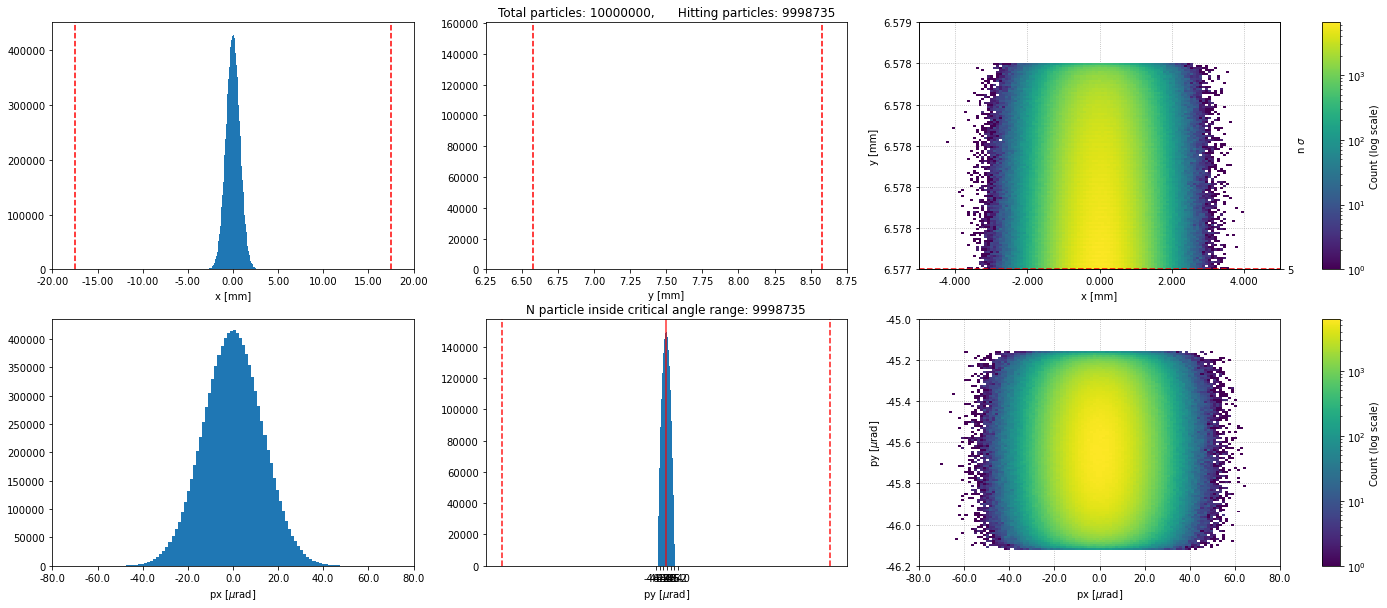

In [44]:
TCCS_chann.compute_impact_particles(xpcrit = True)

In [45]:
TCCP_chann.load_particles('TEST_BAD_MAYBEFIXED__20241025-2119', 'TCCP_impacts', get_absorbed='all')

: 

### local


In [215]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='VC')

KeyError: 'No object named VC in the file'

In [216]:
r = 9.99806e+00
xp = 1.1806013e-05
t_I =1.8320647e-21	
r*np.sin(xp-t_I)*np.cos(xp)/1e-4

1.1803722632381182

In [217]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='chann')

,id,p0c_bef,t_I_bef,t_P_bef,r_bef,p0c,t_I,t_P,r,L_chan,pc
0,25,4.50000e+11,3.07850e-25,0.00000e+00,8.00000e+01,4.50000e+11,3.07850e-25,5.00000e-05,8.00000e+01,4.00000e-03,4.50001e+02
1,50,4.50000e+11,2.14524e-26,0.00000e+00,8.00000e+01,4.50000e+11,2.14524e-26,5.00000e-05,8.00000e+01,4.00000e-03,4.50001e+02
2,26,4.50000e+11,1.62541e-25,5.00000e-05,8.00000e+01,4.50000e+11,1.62541e-25,5.00000e-05,8.00000e+01,4.00000e-03,4.50001e+02
3,51,4.50000e+11,7.02780e-27,5.00000e-05,8.00000e+01,4.50000e+11,7.02780e-27,5.00000e-05,8.00000e+01,4.00000e-03,4.50001e+02
4,27,4.50000e+11,2.88302e-25,5.00000e-05,8.00000e+01,4.50000e+11,2.88302e-25,5.00000e-05,8.00000e+01,4.00000e-03,4.50001e+02
...,...,...,...,...,...,...,...,...,...,...,...
225,97,4.50000e+11,7.12092e-22,6.99997e-03,9.99924e+00,4.50000e+11,7.12092e-22,6.99997e-03,9.99924e+00,6.99944e-02,4.50000e+02
226,79,4.50000e+11,1.26542e-21,5.00000e-05,9.99867e+00,4.50000e+11,1.26542e-21,6.99997e-03,9.99867e+00,6.99904e-02,4.50000e+02
227,94,4.50000e+11,6.78998e-22,6.99997e-03,9.99929e+00,4.50000e+11,6.78998e-22,6.99997e-03,9.99929e+00,6.99948e-02,4.50000e+02
228,27,4.50000e+11,1.22306e-21,6.99997e-03,9.99870e+00,4.50000e+11,1.22306e-21,6.99997e-03,9.99870e+00,6.99906e-02,4.50000e+02


In [218]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='AM')

,id,pc_bef,pc,length_VI,p0c_bef,p0c
0,65,4.50001e+02,4.50001e+02,1.18093e-04,4.50000e+11,4.5000000e+11
1,68,4.50001e+02,4.50001e+02,5.35483e-05,4.50000e+11,4.5000000e+11
2,69,4.50001e+02,4.50001e+02,1.16474e-06,4.50000e+11,4.5000000e+11
3,5,4.50001e+02,4.50000e+02,9.70582e-04,4.50000e+11,4.5000000e+11
4,10,4.50001e+02,4.50001e+02,5.33650e-04,4.50000e+11,4.5000000e+11
5,66,4.50000e+02,4.50000e+02,9.68282e-05,4.50000e+11,4.5000000e+11
6,15,4.50000e+02,4.50000e+02,1.24145e-04,4.50000e+11,4.5000000e+11
7,37,4.50001e+02,4.50001e+02,3.03403e-04,4.50000e+11,4.5000000e+11
8,88,4.50000e+02,4.50000e+02,9.45076e-05,4.50000e+11,4.5000000e+11
9,80,4.50000e+02,4.50000e+02,8.77012e-05,4.50000e+11,4.5000000e+11


In [219]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='DCH')

,id,pc_very_before,pc_bef,pc,channeled_length,length,L_dechan,L_chan,t_I,t_P
0,65,4.50001e+02,4.50001e+02,4.49999e+02,1.40010e-03,4.00000e-03,1.40010e-03,4.00000e-03,2.61685e-25,5.00000e-05
1,68,4.50001e+02,4.50001e+02,4.49999e+02,8.35025e-04,4.00000e-03,8.35025e-04,4.00000e-03,-1.79270e-25,5.00000e-05
2,69,4.50001e+02,4.50001e+02,4.49999e+02,9.28939e-04,4.00000e-03,9.28939e-04,4.00000e-03,5.07294e-26,5.00000e-05
3,5,4.50001e+02,4.50001e+02,4.49999e+02,6.54575e-04,4.00000e-03,6.54575e-04,4.00000e-03,6.81778e-26,5.00000e-05
4,33,4.50001e+02,4.50000e+02,4.49999e+02,2.04224e-03,4.00000e-03,2.04224e-03,4.00000e-03,1.47175e-25,5.00000e-05
5,81,4.50001e+02,4.50000e+02,4.50000e+02,3.93600e-03,4.00000e-03,3.93600e-03,4.00000e-03,1.83046e-25,5.00000e-05
6,18,4.50001e+02,4.50000e+02,4.49999e+02,1.71555e-03,4.00000e-03,1.71555e-03,4.00000e-03,2.58090e-25,5.00000e-05
7,36,4.50001e+02,4.50001e+02,4.49999e+02,7.29557e-04,4.00000e-03,7.29557e-04,4.00000e-03,-1.05256e-25,5.00000e-05
8,10,4.50001e+02,4.50001e+02,4.49999e+02,5.60385e-04,4.00000e-03,5.60385e-04,4.00000e-03,-1.46241e-25,5.00000e-05
9,37,4.50001e+02,4.50001e+02,4.49999e+02,3.50520e-04,4.00000e-03,3.50520e-04,4.00000e-03,2.14873e-26,5.00000e-05


In [220]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='prob')

,CIAO!
0,ciao
1,ciao
2,ciao
3,ciao
4,ciao
...,...
555,ciao
556,ciao
557,ciao
558,ciao


In [221]:
# pd.set_option('display.max_rows', None)
coll = pd.read_hdf('./Outputdata/particles_B2V.h5', key='coll')
cool_id = coll[coll.only_mcs == '0'].id
cool_id =cool_id.astype(int)
coll

,id,only_mcs_bef,atom_bef,anuc_bef,rho_bef,exenergy_bef,bnref_ref,only_mcs,zatom,anuc,rho,exenergy,bnref
0,85,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
1,86,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
2,87,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
3,65,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
4,88,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,98,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
159,94,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
160,27,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
161,24,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"


In [222]:
tccs_imp = pd.read_hdf('./Outputdata/particles_B2V.h5', key='TCCS_impacts')
id_lost = tccs_imp[tccs_imp.at_element == 75543].particle_id
tccs_imp

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,TCCS_turn,TCCP_turn,TCP_turn,interactions
0,3.388132e-21,-0.000863,-9.629235e-06,0.006578,-0.000046,0.0,0,0,75543,0,0,None,None,CH
1,0.000000e+00,-0.000193,-8.725743e-06,0.006578,-0.000046,0.0,0,1,75543,0,0,0,None,CH
2,0.000000e+00,0.001486,2.265876e-05,0.006578,-0.000046,0.0,0,2,75543,0,0,None,None,CH
3,0.000000e+00,0.000515,1.855484e-06,0.006578,-0.000046,0.0,0,3,75543,0,0,0,None,CH
4,3.388132e-21,-0.000111,1.066098e-05,0.006578,-0.000046,0.0,0,4,0,1,0,0,None,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.388132e-21,-0.001400,-1.707602e-05,0.006577,-0.000046,0.0,0,95,75036,0,0,0,None,CH
96,0.000000e+00,0.000381,4.649055e-06,0.006578,-0.000046,0.0,0,96,0,1,0,None,None,"VRCH,MCS"
97,0.000000e+00,-0.000813,-2.312519e-05,0.006578,-0.000046,0.0,0,97,75036,0,0,0,None,CH
98,0.000000e+00,-0.000667,-1.750332e-07,0.006578,-0.000046,0.0,0,98,75543,0,0,0,None,CH


In [223]:
tccp_imp = pd.read_hdf('./Outputdata/particles_B2V.h5', key='TCCP_impacts')
tccp_ids = tccp_imp.particle_id
tccp_ids

0      0
1      1
2      2
3      3
4      4
      ..
75    93
76    94
77    95
78    97
79    98
Name: particle_id, Length: 80, dtype: int32

In [224]:
id_alive = tccs_imp[tccs_imp.at_element == 0].particle_id
id_alive

4      4
5      5
9      9
10    10
11    11
      ..
87    87
91    91
92    92
96    96
99    99
Name: particle_id, Length: 34, dtype: int32

In [225]:
cool_id[cool_id.isin(id_alive)]

1      86
2      87
3      65
5      66
8      68
       ..
138    62
140    42
145    91
149    76
152    44
Name: id, Length: 44, dtype: int64

In [226]:
cool_id[cool_id.isin(tccp_ids)]


0      85
1      86
2      87
4      88
5      66
       ..
158    98
159    94
160    27
161    24
162    28
Name: id, Length: 143, dtype: int64

In [227]:
tccp_ids[~tccp_ids.isin(cool_id)]


Series([], Name: particle_id, dtype: int32)

In [228]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='idx')

,0
0,alive
75036,vmgab.4l3.b.b2_aper
75543,tcla.a5l3.b2
81357,mq.30r2.b2..1_aper
75046,vcelh.4l3.b.b2_aper
75016,tccp.4l3.b2
75181,mqwb.4l3.b2..3_aper


In [229]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='ch_trans')

,id,pc_bef,pc,L_chan,energy_loss,drift_length
0,85,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
1,86,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
2,87,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
3,65,4.50001e+02,4.50001e+02,1.40010e-03,2.82958e-01,1.40010e-03
4,88,4.50001e+02,4.50000e+02,4.00000e-03,2.82958e-01,4.00000e-03
...,...,...,...,...,...,...
110,97,4.50000e+02,4.49980e+02,6.99944e-02,2.82958e-01,6.99938e-02
111,79,4.50000e+02,4.49980e+02,6.99904e-02,2.82958e-01,6.99898e-02
112,94,4.50000e+02,4.49980e+02,6.99948e-02,2.82958e-01,6.99942e-02
113,27,4.50000e+02,4.49980e+02,6.99906e-02,2.82958e-01,6.99901e-02


In [230]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='coll')

,id,only_mcs_bef,atom_bef,anuc_bef,rho_bef,exenergy_bef,bnref_ref,only_mcs,zatom,anuc,rho,exenergy,bnref
0,85,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
1,86,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
2,87,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
3,65,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
4,88,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,98,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
159,94,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
160,27,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"
161,24,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,"1.20140e+02,"


In [231]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='coll_init')

,id,only_mcs,atom,anuc,rho,exenergy,bnref,eum,iniinit
0,0,1,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0
1,0,1,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0
2,0,1,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0
3,0,1,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0
4,0,1,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0
...,...,...,...,...,...,...,...,...,...
2691,25,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,2.13400e+01,0
2692,75,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,4.41000e-01,1
2693,75,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,2.13400e+01,0
2694,95,0,1.40000e+01,2.80800e+01,2.33000e+00,1.73000e-04,1.20140e+02,4.41000e-01,1


In [232]:
pd.read_hdf('./Outputdata/particles_B2V.h5', key='scatt')

,ecmsq,xln15s,bpp,xintl,bn,cprob0,cprob1,cprob2,cprob3,cprob4,cprob5
0,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
1,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
2,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
3,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
4,8.44447e+02,4.84156e+00,1.20045e+01,3.01897e-01,1.19866e+02,0.00000e+00,6.47209e-01,9.00056e-01,9.52512e-01,9.99412e-01,1.00000e+00
...,...,...,...,...,...,...,...,...,...,...,...
343,8.44399e+02,4.84151e+00,1.20044e+01,2.58522e-01,1.20020e+02,0.00000e+00,6.49733e-01,8.98217e-01,9.51675e-01,9.99470e-01,1.00000e+00
344,8.44405e+02,4.84151e+00,1.20044e+01,2.58522e-01,1.20020e+02,0.00000e+00,6.49733e-01,8.98217e-01,9.51675e-01,9.99470e-01,1.00000e+00
345,8.44445e+02,4.84156e+00,1.20045e+01,6.02840e-02,3.91678e+02,0.00000e+00,5.76800e-01,9.51002e-01,9.75683e-01,9.97750e-01,1.00000e+00
346,8.44367e+02,4.84147e+00,1.20044e+01,6.02841e-02,3.91678e+02,0.00000e+00,5.76800e-01,9.51002e-01,9.75683e-01,9.97750e-01,1.00000e+00


In [233]:
column_names = ['CIAO']

# Read the text file into a pandas DataFrame
df = pd.read_csv('./prob.txt', sep=', ', header=None, names=column_names, engine='python')
df
        

,CIAO
0,ciao
1,ciao
2,ciao
3,ciao
4,ciao
...,...
555,ciao
556,ciao
557,ciao
558,ciao


In [18]:
display_rows(10)

In [12]:
column_names = ['CIAO']

# Read the text file into a pandas DataFrame
df = pd.read_csv('./coll.txt', sep=', ', header=None, names=column_names, engine='python')
df
        

,,,,,,,,,,,,CIAO
id=0,only_mcs_bef=122,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=122,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=1,only_mcs_bef=122,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=122,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=2,only_mcs_bef=122,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=122,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=3,only_mcs_bef=122,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=122,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=4,only_mcs_bef=122,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=122,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
...,...,...,...,...,...,...,...,...,...,...,...,...
id=93,only_mcs_bef=0,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=0,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=94,only_mcs_bef=0,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=0,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=95,only_mcs_bef=0,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=0,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"
id=97,only_mcs_bef=0,zatom_bef=1.40000e+01,anuc_bef=2.80800e+01,rho_bef=2.33000e+00,exenergy_bef=1.73000e-04,bnref_ref=1.20140e+02,only_mcs=0,zatom=1.40000e+01,anuc=2.80800e+01,rho=2.33000e+00,exenergy=1.73000e-04,"bnref=1.20140e+02,"


In [20]:
# Remove the text before the '=' for each column
for col in df.columns:
    df[col] = df[col].str.replace(r'\w+=', '', regex=True)

df

,pc,plen,Tmax,exenergy,rho,anuc,zatom,momentum,energ,gammar,betar,bgr,mep
0,4.50001e+02,3.10583e-05,1.54415e+05,1.73000e-04,2.33000e+00,2.80800e+01,1.40000e+01,4.50001e+05,4.50002e+05,4.79607e+02,9.99998e-01,4.79606e+02,5.44617e-04
1,4.50001e+02,3.10583e-05,1.54415e+05,1.73000e-04,2.33000e+00,2.80800e+01,1.40000e+01,4.50001e+05,4.50002e+05,4.79607e+02,9.99998e-01,4.79606e+02,5.44617e-04
2,4.50001e+02,3.10583e-05,1.54415e+05,1.73000e-04,2.33000e+00,2.80800e+01,1.40000e+01,4.50001e+05,4.50002e+05,4.79607e+02,9.99998e-01,4.79606e+02,5.44617e-04
3,4.50001e+02,3.10583e-05,1.54415e+05,1.73000e-04,2.33000e+00,2.80800e+01,1.40000e+01,4.50001e+05,4.50002e+05,4.79607e+02,9.99998e-01,4.79606e+02,5.44617e-04
4,4.50001e+02,3.10583e-05,1.54415e+05,1.73000e-04,2.33000e+00,2.80800e+01,1.40000e+01,4.50001e+05,4.50002e+05,4.79607e+02,9.99998e-01,4.79606e+02,5.44617e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9464,4.49961e+02,7.79106e-05,1.54392e+05,6.82200e-04,1.80000e+01,1.66700e+02,6.77000e+01,4.49961e+05,4.49962e+05,4.79565e+02,9.99998e-01,4.79564e+02,5.44617e-04
9465,4.49961e+02,7.79106e-05,1.54392e+05,6.82200e-04,1.80000e+01,1.66700e+02,6.77000e+01,4.49961e+05,4.49962e+05,4.79565e+02,9.99998e-01,4.79564e+02,5.44617e-04
9466,4.49961e+02,7.79106e-05,1.54392e+05,6.82200e-04,1.80000e+01,1.66700e+02,6.77000e+01,4.49961e+05,4.49962e+05,4.79565e+02,9.99998e-01,4.79564e+02,5.44617e-04
9467,4.49961e+02,7.79106e-05,1.54392e+05,6.82200e-04,1.80000e+01,1.66700e+02,6.77000e+01,4.49961e+05,4.49962e+05,4.79565e+02,9.99998e-01,4.79564e+02,5.44617e-04


In [33]:
save_list = ["TCCS_impacts", 'TCCP_impacts', 'PIXEL_impacts_2' ] 
if 'PIXEL_impacts' in save_list or 'PIXEL_impacts_1' in save_list or 'PIXEL_impacts_ALL' in save_list:
    print('yes')


In [144]:
A = pd.read_hdf('./randtest1.h5', key='TCCS_impacts')

In [145]:
B=pd.read_hdf('./Outputdata/particles_B2V.h5', key='TCCS_impacts')

In [146]:
A == B

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,TCCS_turn,TCCP_turn,TCP_turn,interactions
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,True,True,True,True,True,True,True,True,True,True,True,True,True,True
996,True,True,True,True,True,True,True,True,True,True,True,True,True,True
997,True,True,True,True,True,True,True,True,True,True,True,True,True,True
998,True,True,True,True,True,True,True,True,True,True,True,True,True,True
